# SPECIES PREDICTION MODEL PIPELINE (Deep Learning)

In this notebook, we will train a deep learning model to understand patterns in the data of fishes collected from `field`. To train the model, we use a supervised learning approach. We use the results from the genetics lab as the truth and allow the model to learn from the results of the lab. 

This notebook is used for training the model and it need not be re-run unless there is a difference in the data being used. If you only want to predict for new data, the trained model from this notebook has been saved in `/model` and can be called for predition. A demo of this has been done in `model_prediction.ipynb`.

The data used for this model has been extracted from the "field" table using a SQL query. This query can be found in `sql_for_data.md`

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("../imputation_model/raw_data/field_genetics_species.csv")
df.head()

,date,watershed,river,site,method,local,water_temp_start,fork_length_mm,annoted_species,confirmed_species,tag_id_long
0,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,coho,989.001038864826
1,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864862
2,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864891
3,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864827
4,2021-06-02,puntledge,puntledge,above tsolum,beach seine,in-river,13.4,85.0,ck,chinook,989.001038864865


In [3]:
df.annoted_species.unique()

array(['ck', 'co', 'rbt', nan], dtype=object)

In [4]:
df.confirmed_species.unique()

array(['coho', 'chinook', 'steelhead'], dtype=object)

In [5]:
df_clean = df.drop(['tag_id_long', 'water_temp_start'], axis = 1)
df_clean = df_clean.dropna()

In [6]:
df_clean.isnull().sum()

date                 0
watershed            0
river                0
site                 0
method               0
local                0
fork_length_mm       0
annoted_species      0
confirmed_species    0
dtype: int64

In [7]:
df_sampled = df_clean[df_clean['confirmed_species'] == 'chinook'].sample(n=300, random_state=42)
others_combined = df_clean[df_clean['confirmed_species'].isin(["coho", "steelhead"])]
df_sampled = pd.concat([df_sampled, others_combined], axis=0)
df_sampled = df_sampled.reset_index(drop=True)

In [8]:
df_sampled.head()

,date,watershed,river,site,method,local,fork_length_mm,annoted_species,confirmed_species
0,2022-06-17,puntledge,puntledge,little mexico,beach seine,marine,93.0,ck,chinook
1,2022-06-06,nanaimo,nanaimo,jack point,beach seine,marine,69.0,ck,chinook
2,2021-06-07,nanaimo,nanaimo,jack point,beach seine,marine,79.0,ck,chinook
3,2022-06-01,nanaimo,nanaimo,jack point,beach seine,marine,62.0,ck,chinook
4,2021-06-11,nanaimo,nanaimo,cedar bridge,beach seine,in-river,89.0,ck,chinook


## Pipeline

In [9]:
X = df_sampled.drop(['confirmed_species', 'annoted_species'], axis = 1)
y = df_sampled['confirmed_species']

In [10]:
X["year"] = pd.DatetimeIndex(X['date']).year
X['day_of_year'] = pd.to_datetime(X['date']).dt.dayofyear
X.head()

,date,watershed,river,site,method,local,fork_length_mm,year,day_of_year
0,2022-06-17,puntledge,puntledge,little mexico,beach seine,marine,93.0,2022,168
1,2022-06-06,nanaimo,nanaimo,jack point,beach seine,marine,69.0,2022,157
2,2021-06-07,nanaimo,nanaimo,jack point,beach seine,marine,79.0,2021,158
3,2022-06-01,nanaimo,nanaimo,jack point,beach seine,marine,62.0,2022,152
4,2021-06-11,nanaimo,nanaimo,cedar bridge,beach seine,in-river,89.0,2021,162


In [11]:
numeric_feats = ["fork_length_mm", "day_of_year"]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local", "year"]  # apply one-hot encoding
drop_feats = [ "date" ]  

In [12]:
ct = make_column_transformer (    
    (StandardScaler(), numeric_feats),      
    (OneHotEncoder(), categorical_feats),  
    ("drop", drop_feats)
)

In [13]:
transformed = ct.fit_transform(X)

In [14]:
column_names = (
    numeric_feats
    # + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['fork_length_mm',
 'day_of_year',
 'watershed_nanaimo',
 'watershed_puntledge',
 'river_nanaimo',
 'river_puntledge',
 'site_above tsolum',
 'site_cedar bridge',
 'site_condensory bridge',
 'site_jack point',
 'site_little mexico',
 'site_living forest',
 'site_newcastle',
 'site_snuneymuxw beach',
 'site_tsolum confluence',
 'method_beach seine',
 'local_in-river',
 'local_marine',
 'year_2021',
 'year_2022',
 'year_2023']

In [15]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,fork_length_mm,day_of_year,watershed_nanaimo,watershed_puntledge,river_nanaimo,river_puntledge,site_above tsolum,site_cedar bridge,site_condensory bridge,site_jack point,...,site_living forest,site_newcastle,site_snuneymuxw beach,site_tsolum confluence,method_beach seine,local_in-river,local_marine,year_2021,year_2022,year_2023
0,-0.280810,0.733807,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-1.354080,-0.898374,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.906884,-0.749994,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,-1.667117,-1.640275,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.459688,-0.156474,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Dummy model

In [16]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.49586776859504134

### Deep learning - tensorflow

In [17]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_label = tf.keras.utils.to_categorical(y_enc)

In [18]:
le.classes_ 

array(['chinook', 'coho', 'steelhead'], dtype=object)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_label, test_size=0.2, random_state=42)

In [20]:
num_features = X_transformed.shape[1]
dl_model = tf.keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  #change based on number of labels
])

In [21]:
dl_model.compile(optimizer=Adam(learning_rate=0.0001),        
    loss='categorical_crossentropy',  
    metrics=['accuracy']) 

dl_model.summary()

Model: "sequential"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2816      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11,267
Trainable params: 11,267
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = dl_model.fit(X_train, y_train, 
                    epochs = 20, 
                    batch_size = 32, 
                    validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 46ms/step - loss: 1.1449 - accuracy: 0.4057 - val_loss: 1.0781 - val_accuracy: 0.4845
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 1.0568 - accuracy: 0.5142 - val_loss: 0.9965 - val_accuracy: 0.5773
Epoch 3/20
13/13 [==============================] - 0s 5ms/step - loss: 0.9787 - accuracy: 0.5840 - val_loss: 0.9238 - val_accuracy: 0.6495
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.9077 - accuracy: 0.6202 - val_loss: 0.8599 - val_accuracy: 0.7010
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.8447 - accuracy: 0.6951 - val_loss: 0.8037 - val_accuracy: 0.8041
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 0.7890 - accuracy: 0.7674 - val_loss: 0.7526 - val_accuracy: 0.8247
Epoch 7/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7364 - accuracy: 0.8217 - val_loss: 0.7041 - val_accuracy: 0.8866
Epoch 8/20
13/13 [=

In [23]:
def plot_acc(history):
    fig = plt.figure(0, (12, 4))

    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

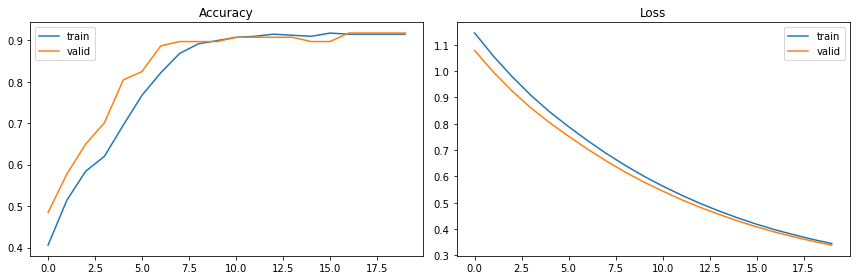

In [24]:
plot_acc(history)

### Saving the model

In [25]:
dl_model.save('model/imputation_model.h5')

### Validation

In [26]:
y_pred = dl_model.predict(X_test)

4/4 [==============================] - 0s 4ms/step


In [27]:
prediction = pd.DataFrame(y_pred, columns=le.classes_)
prediction.head()

,chinook,coho,steelhead
0,0.120443,0.848427,0.031130
1,0.709882,0.239340,0.050777
2,0.636605,0.316002,0.047393
3,0.767391,0.151638,0.080971
4,0.673628,0.264079,0.062293


In [28]:
max_val = []
max_label = []
for i in range(prediction.shape[0]):
    max_val.append(prediction.iloc[i].max())
    max_label.append(prediction.iloc[i].idxmax())

In [29]:
tested_data = pd.DataFrame(y_test, columns = le.classes_ )

label_y = []
for i in range(tested_data.shape[0]):
    label_y.append(tested_data.iloc[i].idxmax())

In [30]:
new_df = pd.DataFrame({
    'original_label' : label_y,
    'predicted_label': max_label,
    'confidence': max_val
})
new_df

,original_label,predicted_label,confidence
0,coho,coho,0.848427
1,chinook,chinook,0.709882
2,chinook,chinook,0.636605
3,chinook,chinook,0.767391
4,chinook,chinook,0.673628
...,...,...,...
116,chinook,chinook,0.570081
117,chinook,chinook,0.839170
118,coho,coho,0.803004
119,coho,coho,0.912923


In [31]:
correct = len(new_df[new_df["original_label"]==new_df["predicted_label"]])

In [32]:
print("Testing accuracy: ", round(correct/new_df.shape[0], 3))

Testing accuracy:  0.959
